In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import numpy as np

#### setting up

In [49]:
base_dir = os.path.abspath('../data/processed')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

IMG_SIZE = 150  # We force all images to this squared size (150x150): small enough but still detailed for our case
BATCH_SIZE = 32 # We feed 32 images at a time to the model: it's enough images to get a good "average" of what the data looks like.

print(f"Training on data from: {train_dir}")
print(f"Validating on data from: {val_dir}")

Training on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/train
Validating on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/val


### generators definition for proper training and evaluation

In [50]:
# Train with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values (0-1)
    rotation_range=40,      # Twist up to 40 degrees
    width_shift_range=0.2,  # Move Left/Right 20%
    height_shift_range=0.2, # Move Up/Down 20%
    shear_range=0.2,        # Slant/Perspective distortion
    zoom_range=0.2,         # Zoom in/out 20%
    horizontal_flip=True,   # Mirror flip
    fill_mode='nearest'     # Fill gaps with neighbor color
)

# Validation;
val_datagen = ImageDataGenerator(rescale=1./255)

# load the data
# flow_from_directory looks at the folder directory and extracts images  atomatically assigning them the proper label given the 
# fact they belong to a certain subfolder (rock, paper or scissors)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Validation Data...")
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Loading Training Data...
Found 1531 images belonging to 3 classes.
Loading Validation Data...
Found 326 images belonging to 3 classes.


## Model 1

#### Model specification: a really basic CNN

In [51]:
model = models.Sequential([
    # Block 1: Very few filters (16)
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    # Block 2: more filter to capture the more complex shapes (32)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),

    # Dense Layer
    layers.Dense(64, activation='relu'),
    
    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,555 (10.15 MB)

 Trainable params: 2,659,555 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile the model using cross-entropy, adam as optimizer and accuracy to evaluate

In [52]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Baseline Model (Shallow) Ready for Training.")

Baseline Model (Shallow) Ready for Training.


##### early stopping and reduce LR on Plateau

In [53]:
# EarlyStopping: Stop if the model stops improving for 5 epochs (prevents wasting time)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: If the model gets stuck, lower the learning rate to help it find the "sweet spot" when the loss value doesn't decrese after 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Multiply LR by 0.2
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

#### Training

In [54]:
print("Starting training...")

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training Complete!")

Starting training...
Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.4076 - loss: 1.1764 - val_accuracy: 0.6043 - val_loss: 0.9812 - learning_rate: 0.0010
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.4683 - loss: 1.0210 - val_accuracy: 0.6411 - val_loss: 0.9382 - learning_rate: 0.0010
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.5212 - loss: 0.9529 - val_accuracy: 0.4724 - val_loss: 0.9172 - learning_rate: 0.0010
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.5918 - loss: 0.8827 - val_accuracy: 0.5552 - val_loss: 0.8059 - learning_rate: 0.0010
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.6982 - loss: 0.7384 - val_accuracy: 0.7853 - val_loss: 0.4680 - learning_rate: 0.0010
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.7858 - loss: 0.5729 - val_accuracy: 0.8190 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8

In [59]:
# Define where to save the model
# We typically use the 'models' folder in your project structure
save_path = os.path.abspath('../models/model_1.keras')

# Save the entire model (architecture + weights + optimizer state)
model.save(save_path)

print(f"Baseline Model saved successfully at: {save_path}")

Baseline Model saved successfully at: /Users/paolominini/Projects/rps-cnn-classifier/models/model_1.keras


#### Plot the results

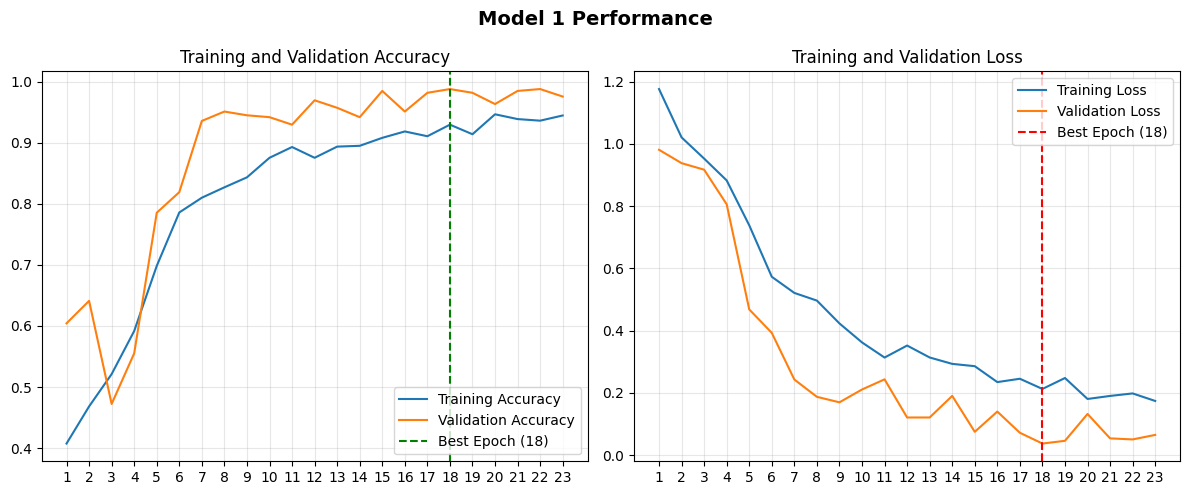

Best model was restored from Epoch 18 (Lowest Val Loss: 0.0368)


In [60]:
# extract data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1) # Shift the range to start at 1 instead of 0

# Find best epoch and add 1 (to match the shifted range)
best_epoch_idx = val_loss.index(min(val_loss))
best_epoch = best_epoch_idx + 1

# actual plot
plt.figure(figsize=(12, 5))

# - accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Add vertical line at best epoch
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xticks(epochs_range)

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True, alpha=0.3) 

# - loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Add vertical line at best epoch
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')

# 3. FIX: Force the x-axis to show only our integer epochs
plt.xticks(epochs_range)

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True, alpha=0.3)

plt.suptitle('Model 1 Performance', fontweight='bold', fontsize=14)
plt.tight_layout()

# Save and Show
save_path_image = os.path.abspath('../reports/figures/training_history_1.png')
plt.savefig(save_path_image)
plt.show()

# Print the final result cleanly
print(f"Best model was restored from Epoch {best_epoch} (Lowest Val Loss: {min(val_loss):.4f})")

In [61]:
print(f"Validation accuracy value: {max(val_acc):.4f}")

Validation accuracy value: 0.9877


### **Model 1 Analysis: The "Shallow" Baseline**

**1. Architecture Design and training:**
We established a minimal baseline using a shallow Convolutional Neural Network (CNN) with only **2 Convolutional Blocks** (16 and 32 filters respectively). This architecture was intentionally restricted in capacity (parameter count) and lacked advanced regularization techniques like Dropout or Batch Normalization. The training was implemented with at most 25 number of epochs and using both Early Stopping (patience = 5) and ReduceLROnPlateau (patience = 3)

**2. Performance & Observations:**
Contrary to the expectation of underfitting, the model achieved **high validation accuracy (>98%)** and demonstrated stable convergence.
* **No Overfitting:** The validation accuracy consistently tracked or exceeded training accuracy, confirming that our Data Augmentation pipeline provided sufficient regularization even without Dropout layers.
* **Rapid Convergence:** The model learned the core features (hand silhouettes) very quickly, often within the first 5-8 epochs.

**3. Scientific Interpretation:**
The success of such a simple architecture highlights the **high signal-to-noise ratio** of the dataset.
* **Distinct Features:** The classes (Rock vs. Paper vs. Scissors) have geometrically distinct contours that are easily separable by basic edge detection filters.
* **Clean Background:** The uniform green background eliminates "clutter," allowing even a shallow network to isolate the hand without needing deep, hierarchical feature extraction.

**Conclusion:**
While Model 1 solves the immediate task, its simplicity may lack robustness against complex real-world backgrounds or lighting variations. We will now proceed to **Model 2 (Deep CNN)** to test if increasing network depth improves confidence or feature granularity.

### Mistakes check

Found 326 images belonging to 3 classes.
Predicting on Validation Set...
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Total Errors: 4 out of 326 images


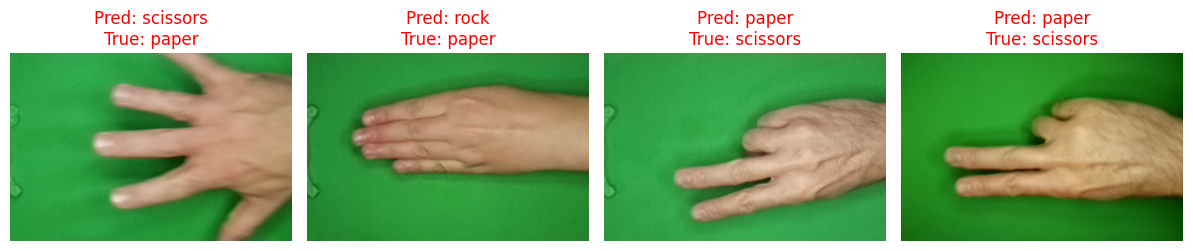

In [62]:
# audit generator.
# We need this to match filenames to predictions 1-to-1
audit_datagen = ImageDataGenerator(rescale=1./255)
audit_generator = audit_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # the one thing different from the usual train and val_generators (in order to allow to recover the correct image)
)

# get predictions
print("Predicting on Validation Set...")
predictions = model.predict(audit_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = audit_generator.classes
class_labels = list(audit_generator.class_indices.keys()) # ['paper', 'rock', 'scissors']

# find errors
# Get the indices where Prediction doesn't match the true value
errors = np.where(predicted_classes != true_classes)[0]
print(f"Total Errors: {len(errors)} out of {len(true_classes)} images")

# plot the mistakes
if len(errors) > 0:
    plt.figure(figsize=(15, 10))
    
    # We will show up to 10 errors
    num_to_show = min(10, len(errors))
    
    for i in range(num_to_show):
        error_index = errors[i]
        
        # Get the actual image file path
        image_path = audit_generator.filepaths[error_index]
        
        # Load and plot
        img = plt.imread(image_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        
        # Title: "Pred: Rock / True: Paper"
        pred_label = class_labels[predicted_classes[error_index]]
        true_label = class_labels[true_classes[error_index]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.abspath('../reports/figures/mistakes_1.png'))
    plt.show()
else:
    print("The model made zero mistakes on the validation set.")